In [2]:
import pandas as pd
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import tree
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [3]:
class Plotting:
    """ Contains the stuff for plotting. """

    color1 = ("#f02c46") #rocketloop red
    color2 = ("#00b9ee") #rocketloop blue
    def __init__(self, data):
        """ Instantiates the data for the plotting. """
        self.data = data
        
    def plot_roc_curve(self, classification_reports):
        """ Plots the as an array given classification reports roc curves. """
        #create the plots
        if len(classification_reports) > 2:
            fig, ax = plt.subplots(ncols = 2, nrows = int(len(classification_reports)/2) + len(classification_reports) % 2)
            #removes last ax if uneven:
            if (len(classification_reports) % 2) == 1:
                fig.delaxes(ax[int(len(ax) - 1), 1])
            for i in range(len(classification_reports)):
                ax[int(i/2), i%2].plot(classification_reports[i].fpr, classification_reports[i].tpr, \
                    label='%s (area = %0.2f)' % (classification_reports[i].label, classification_reports[i].logit_roc_auc),\
                        color = Plotting.color2)
                # plots the f(x) = x line:
                ax[int(i/2), i%2].plot([0, 1], [0, 1], color = Plotting.color1)
                ax[int(i/2), i%2].set_xlim([0.0, 1.0])
                ax[int(i/2), i%2].set_ylim([0.0, 1.0])
                ax[int(i/2), i%2].set_title(classification_reports[i].label)
                ax[int(i/2), i%2].set_ylabel('True Positive Rate')
                ax[int(i/2), i%2].set_xlabel('False Positive Rate')
                ax[int(i/2), i%2].legend(loc="lower right")


        elif len(classification_reports) == 2:
            fig, ax = plt.subplots(ncols = 2, nrows = 1)
            for i in range(len(classification_reports)):
                ax[i].plot(classification_reports[i].fpr, classification_reports[i].tpr, \
                    label='%s (area = %0.2f)' % (classification_reports[i].label, classification_reports[i].logit_roc_auc),\
                        color = Plotting.color2)
                # plots the f(x) = x line:
                ax[i].plot([0, 1], [0, 1], color = Plotting.color1)
                ax[i].set_xlim([0.0, 1.0])
                ax[i].set_ylim([0.0, 1.0])
                ax[i].set_title(classification_reports[i].label)
                ax[i].set_ylabel('True Positive Rate')
                ax[i].set_xlabel('False Positive Rate')
                ax[i].legend(loc="lower right")

        elif len(classification_reports) == 1:
            fig, ax = plt.subplots(ncols = 1, nrows = 1)
            ax.plot(classification_reports[0].fpr, classification_reports[0].tpr, \
                    label='%s (area = %0.2f)' % (classification_reports[0].label, classification_reports[0].logit_roc_auc),\
                        color = Plotting.color2)
                # plots the f(x) = x line:
            ax.plot([0, 1], [0, 1], color = Plotting.color1)
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.0])
            ax.set_title(classification_reports[0].label)
            ax.set_ylabel('True Positive Rate')
            ax.set_xlabel('False Positive Rate')
            ax.legend(loc="lower right")
        
        plt.suptitle('Receiver operating characteristic')
        plt.tight_layout()
        plt.show()
        return

In [4]:
class Data:
    """ This class handles everthing related to the data analysis. 
    
    The Data object holds the train- and testdatasets as well as the column names and the names of the 
    categorical features which are required for categorical classification.\n
    It contains the following object variables:
    names: list of strings containing the labels of the columns
    learndata: pd array of a converted csv file. This data is used for the training.
    testdata: pd array of a converted csv file. This data is used for the testing.
    categorical_features: list of strings containing the labels of all categorical features.
    target: string of the label of the row that contains the target variables of the pd arrays learndata and testdata.
    x_train: pd array that contains the training features.
    y_train: pd array that contains the training targets.
    x_test: pd array that contains the test features.
    y_test: pd array that contains the test targets.


    The following Methods can be used to generate classifier objects of the Data object,
    which can get used for predicting scores and plotting performances and so on.
    They always use the Data object which contains the data they get trained on. \n
    do_log_regr(self): returns a logistical regression classifier object of the Data.
    do_gradient_boosting_trees(self): create a gradient boosting trees classifier object of the Data.
    do_decission_tree(self): returns a decission tree classifier object of the Data.
    do_neural_network(self): returns a neural network classifier object of the Data.
    do_svm(self): returns a support vector machine classifier object of the Data.
    do_kneighbors(self): returns a k-nearest neighbor classifier object of the Data.
    do_naive_bayes(self): returns a naive bayes classifier object of the Data.
    """

    def __init__(self, files, names, categorical_features, target, sep = ","):
        """ Takes files, names and categorical_features as an array of strings as an input. 

        The files have to be entered in a list as following: 1. item is the traindata, 2. item is the testdata.
        (optionally 3. item but this is only important if you want to safe the classification report.)
        The names are used as the names of the rows in the data (last name is always the target).
        The categorical features must be defined as the names of the data which is categorical.
        target: The name of the target value (must be included in names). """
        # This data will be used to analyse the dataset (add variability maybe).
        self.names = names

        self.learndata = pd.read_csv((files[0]), names = self.names, sep=sep)
        self.testdata = pd.read_csv((files[1]), names = self.names, sep=sep)

        self.categorical_features = categorical_features

        self.target = target
        
        self.setup_data()

    def setup_data(self):
        """ Sets up the data so it can be classified. """
        # removes any incomplete data
        learndata = self.remove_incomplete_data(self.learndata)
        testdata = self.remove_incomplete_data(self.testdata)
        
        #split feature and target data
        self.y_train = self.set_target(learndata)
        self.y_test = self.set_target(testdata)

        traindata = learndata.drop(self.target, axis = 1)
        testdata = testdata.drop(self.target, axis = 1)
        temp = len(traindata)
        learndata = traindata.append(testdata, ignore_index = True)
        learndata = self.get_dummies(learndata, self.categorical_features)
        self.x_train = learndata[0:temp]
        self.x_test = learndata[temp:len(learndata)]

    def get_categorical_features(self):
        """ Returns the categorical features of the data as array. """
        return self.categorical_features

    def remove_incomplete_data(self, data):
        """ Removes every row of the data that contains atleast 1 "?". """
        data = data.replace("?", np.nan)
        return data.dropna(0, "any")

    def get_dummies(self, data, categorical_features):
        """ Gets the dummies of the categorical features for the given data. """
        for feature in self.categorical_features:
            try:
                data[feature] = data[feature].str.replace(" ","")
            except(AttributeError):
                pass
            cat_list = pd.get_dummies(data[feature], prefix=feature, drop_first=True)
            data = data.join(cat_list)
        
        # add non categorical features to the data
        data_vars = data.columns.values.tolist()
        to_keep = []
        for i in data_vars:
            if i not in categorical_features:
                to_keep.append(i)
        data = data[to_keep]
        return data

    def set_target(self, data):
        """ Cleans the data by setting targets (0,1 for either case) """
        temp = (data[self.target].unique()) # returns all the unique target values.
        for i in range(len(temp)):
            data[self.target] = np.where(data[self.target] == temp[i], i, data[self.target])
        return data[self.target].astype("int")

    def do_log_regr(self):
        """ Returns a logistic regression classifier object. """
        clf = LogisticRegression(solver = "lbfgs")
        clf.fit(self.x_train, self.y_train)
        return clf
    
    def do_gradient_boosting_trees(self):
        """ Returns a gradient boosting trees classifier object. """
        clf = GradientBoostingClassifier(n_estimators=4000, learning_rate=0.04, max_depth=2, random_state=0)
        clf.fit(self.x_train, self.y_train)
        return clf

    def do_decission_tree(self):
        """ Returns a decission tree classifier object. """
        clf = tree.DecisionTreeClassifier()
        clf.fit(self.x_train, self.y_train)
        return clf
    
    def do_neural_network(self, hidden_layer_size = (100,), max_iter = 200):
        """ Returns a nn classifier object. 
        
        Optional arguments:\n 
        hidden_layer_size: Tuple of ints that defines the size and the amount of hidden layers. (default (100,))) 
        max_iter: Int that defines the maximum amount of training iterations. (default 200) """
        clf = MLPClassifier(hidden_layer_sizes=hidden_layer_size,\
             max_iter=max_iter)
        clf.fit(self.x_train, self.y_train)
        return clf

    def do_svm(self):
        """  Returns an svm classifier object.  """        
        clf = SVC(gamma="auto")
        clf.fit(self.x_train, self.y_train)
        return clf

    def do_kneighbors(self):
        """ Returns a k-nn object. """
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(self.x_train, self.y_train)
        return clf

    def do_naive_bayes(self):
        """ Returns a native bayes classifier object. """
        clf = GaussianNB()
        clf.fit(self.x_train, self.y_train)
        return clf

    def do_gaussian_process_regressor(self):
        """ Returns a gaussian process regressor classifier object. """
        clf = GaussianProcessRegressor()
        clf.fit(self.x_train, self.y_train)
        return clf
    
    def do_dummy_classifier(self):
        """ Returns a dummy classifier object. """
        clf = DummyClassifier()
        clf.fit(self.x_train, self.y_train)
        return clf

    def get_classificaction_report(self, clf, x, y, label = ""):
        """ Returns a ClassificationReport object. 

        Arguments:\n
        clf: The classifier to be reported.\n
        x: The feature values.\n
        y: The target values to validate the predictions. \n
        label: (optionally) sets a label."""
        logit_roc_auc = roc_auc_score(y, clf.predict_proba(x)[:,1])
        fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(x)[:,1])
        predictions = clf.predict(x)
        classification_report = ClassificationReport(metrics.confusion_matrix(y, predictions),\
        metrics.classification_report(y, predictions), logit_roc_auc, fpr, tpr, thresholds , label)
        return classification_report

In [5]:
class ClassificationReport:
    """ Object to Print the classification report data. """
    def __init__(self, matrix, report, logit_roc_auc, fpr, tpr, thresholds, label):
        """ Takes sklearn matrix and report as arguments. """
        self.matrix = matrix
        self.report = report
        self.logit_roc_auc = logit_roc_auc
        self.fpr = fpr
        self.tpr = tpr
        self.thresholds = thresholds
        if label == "":
            self.label = None
        else:
            self.label = label
        
    def __repr__(self):
        """ Object gets represented as a string containing its information. """
        x = "\tt\t" + "f\n" + "n\t" + str(self.matrix[0][0]) + "\t" + str(self.matrix[0][1]) + "\n" + "p\t" + str(self.matrix[1][1]) + "\t" + str(self.matrix[1][0])
        x += ("\n" + self.report)
        return x

    def write_to_file(self, file, args = []):
        """ Writes a ClassificationReport object to a file. 

        Arguments:
        file: The file to write to.
        args: (optional) to display additional information at the beginning. """
        if args == []:
            with open(file, "a") as file:
                file.write(self.__repr__())
        else:
            with open(file, "a") as file:
                file.write(str(args) + "\n" + self.__repr__())

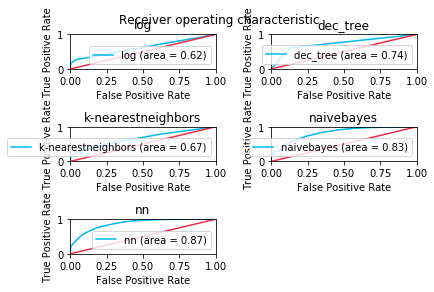

log 
 0.7978011178674529
decision tree
 0.8097782691480867
knn
 0.7767950371598796
naive bayes
 0.7957127940544193
nn
 0.8054787789447823


In [9]:
files = ["./data_files/adult.data.txt", \
    "./data_files/adult.test.txt"]
names = ["age","workclass","fnlwgt","education","education-num",\
            "marital-status","occupation","relationship","race","sex",\
            "capital-gain","capital-loss","hours-per-week","native-country",\
            "income"]
categorical_features = ["workclass","education","race","sex","marital-status","occupation","relationship",\
        "native-country"]
data = Data(files, names, categorical_features, "income")

log = data.do_log_regr()
dec_tree = data.do_decission_tree()
#svm = data.do_svm()
# gbt = data.do_gradient_boosting_trees()
knn = data.do_kneighbors()
naive_bayes = data.do_naive_bayes()
nn = data.do_neural_network((100,100))
classification_reports = []
classification_reports.append(data.get_classificaction_report(log, data.x_test, data.y_test, label = "log"))    
classification_reports.append(data.get_classificaction_report(dec_tree, data.x_test, data.y_test, label = "dec_tree"))
#classification_reports.append(data.get_classificaction_report(svm, data.x_test, data.y_test, label = "svm"))
# classification_reports.append(data.get_classificaction_report(gbt, data.x_test, data.y_test, label = "gbt"))    
classification_reports.append(data.get_classificaction_report(knn, data.x_test, data.y_test, label = "k-nearestneighbors"))
classification_reports.append(data.get_classificaction_report(naive_bayes, data.x_test, data.y_test, label = "naivebayes"))
classification_reports.append(data.get_classificaction_report(nn, data.x_test, data.y_test, label = "nn"))

Plotting.plot_roc_curve(Plotting, classification_reports)

print("log \n", log.score(data.x_test, data.y_test))
print("decision tree\n", dec_tree.score(data.x_test, data.y_test))
# print("gradient boosting\n" , gbt.score(data.x_test, data.y_test),)
print("knn\n", knn.score(data.x_test, data.y_test))
print("naive bayes\n", naive_bayes.score(data.x_test, data.y_test))
print("nn\n", nn.score(data.x_test, data.y_test))
#print("svm\n", svm.score(data.x_test, data.y_test))